In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((10.923157 34.607724, 10.923157 34.837984, 11.406555 34.837984, 11.406555 34.607724, 10.923157 34.607724))"
search_results, total_count = dag.search(
    productType="S2_MSI_L1C",
    geom=geometry,
    start="2023-01-01",
    end="2023-12-31",
    cloudCover=0,
)

In [2]:
import os
os.environ["EODAG__CREODIAS_S3__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.relpath('./Products/downloads')

In [3]:
import rasterio
import pprint

#print all the images available
pprint.pprint(search_results)


[EOProduct(id=S2A_MSIL1C_20230301T100021_N0509_R122_T32SQD_20230301T120008, provider=creodias_s3),
 EOProduct(id=S2A_MSIL1C_20230219T100041_N0509_R122_T32SQD_20230219T120022, provider=creodias_s3),
 EOProduct(id=S2A_MSIL1C_20230219T100041_N0509_R122_T32SPD_20230219T120022, provider=creodias_s3),
 EOProduct(id=S2B_MSIL1C_20230326T100029_N0509_R122_T32SPD_20230326T120026, provider=creodias_s3),
 EOProduct(id=S2B_MSIL1C_20230624T095559_N0509_R122_T32SQD_20230624T120253, provider=creodias_s3),
 EOProduct(id=S2A_MSIL1C_20230629T100031_N0509_R122_T32SQD_20230629T151910, provider=creodias_s3),
 EOProduct(id=S2B_MSIL1C_20230614T095559_N0509_R122_T32SQD_20230614T120216, provider=creodias_s3),
 EOProduct(id=S2A_MSIL1C_20230619T100031_N0509_R122_T32SQD_20230619T134108, provider=creodias_s3),
 EOProduct(id=S2A_MSIL1C_20230410T100031_N0509_R122_T32SQD_20230410T134016, provider=creodias_s3),
 EOProduct(id=S2A_MSIL1C_20230410T100031_N0509_R122_T32SPD_20230410T134016, provider=creodias_s3),
 EOProduct

In [4]:
#donwload the disired image for us it is the 6th
product = search_results[3]
product_path = product.download()

0.00B [00:00, ?B/s]

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


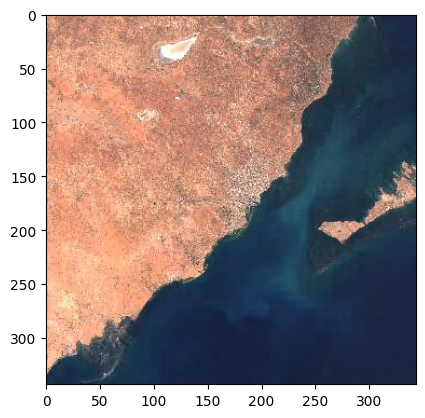

<Axes: >

In [5]:
import glob
# We import the rasterIO library, that can read and display a Georeferenced image
from rasterio.plot import show

# Stores the product name, as it will be used in the next lines to construct the path to the image to show
product_name = product.properties['title']

# Looks for the Preview Image, stores the path. The preview image is quicker to load and display
path = glob.glob('./Products/downloads/'+ product_name + '/*ql.jpg')[0]

# Opens the image with rasterio, a python library
img = rasterio.open(path)

# Plots the preview image
show(img)



In [6]:
import re
product_name = product.properties['title'].replace('.SAFE','')

search_results, _ = dag.search(id=product_name)

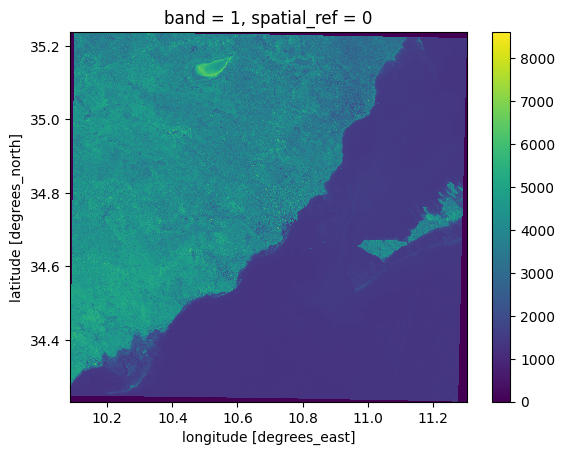

In [7]:
import os
from rasterio.crs import CRS
import rioxarray as xr

get_data_args = dict(
    crs=CRS.from_epsg(4326), 
    resolution=0.0006, 
    extent=product.geometry.bounds
)
# B04 stands for band 4, the NIR band. 
B04 = [b for b in product.assets if "B04" in b and b.split(".")[-1] == "jp2"][0]
data04 = product.get_data(**{"band": B04, **get_data_args})

from matplotlib import pyplot
data04.plot()

#extract the NIR Band

B04_href = product.assets[B04]['href']
B04_href = B04_href.replace('s3://eodata', './eodata')
nir = xr.open_rasterio(B04_href )

In [8]:
#extraxt iamge data as an array
from sklearn.cluster import KMeans
import numpy as np

arr = nir.values
arr = np.moveaxis(arr, 0, -1)
arr = np.where(arr == np.nan, 0, arr)

x_train = arr.reshape(-1, 1)



In [9]:
#KNN
model = KMeans(n_clusters=3)
y_kmeans = model.fit_predict(x_train)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


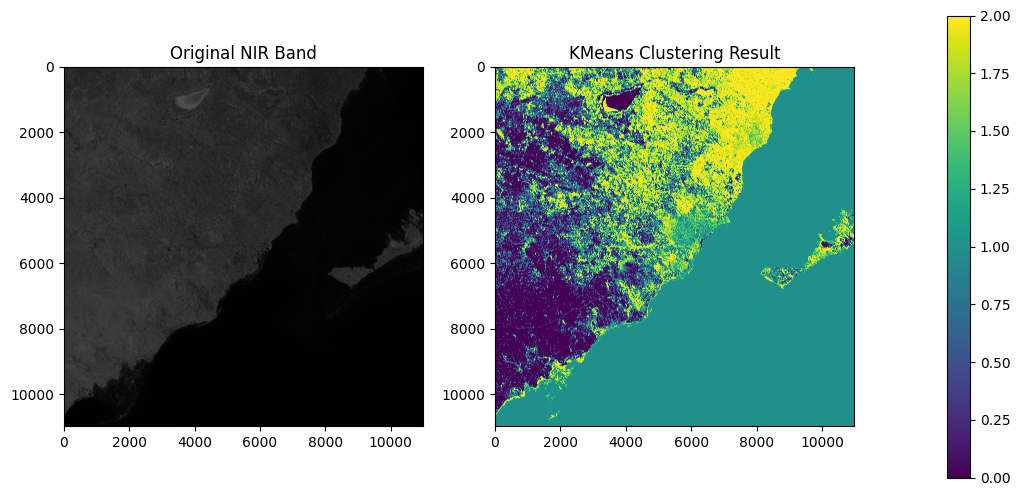

In [10]:
import matplotlib.pyplot as plt
# Reshape the cluster labels to match the original image shape
clustered_image = y_kmeans.reshape(nir.shape[1:])

# Visualize the original NIR band and the clustered image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize the original NIR band
axes[0].imshow(nir.values[0], cmap='gray')  # Assuming the NIR band is at index 0
axes[0].set_title('Original NIR Band')

# Visualize the clustered image
im = axes[1].imshow(clustered_image, cmap='viridis')
axes[1].set_title('KMeans Clustering Result')

# Add colorbar
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.05, pad=0.1)

plt.show()


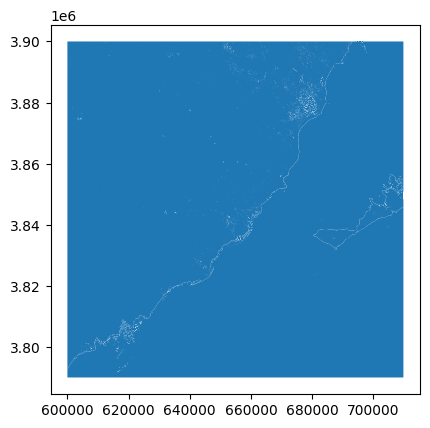

In [11]:
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape

# Create a mask based on the clustering result
mask = (clustered_image == 1)  # Adjust the cluster label as needed

# Use xarray accessor to get the rasterio interface
nir_rio = nir.rio

# Get transformation information from the xarray rasterio interface
transform = nir_rio.transform()
crs = nir_rio.crs

# Transform the mask into shape features
features = rasterio.features.shapes(mask.astype('int16'), transform=transform)

# Extract the geometries and create a GeoDataFrame
geometries = [shape(geometry) for geometry, value in features]
gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)


# Plot the GeoDataFrame
gdf.plot()

# Show the plot
plt.show()

In [12]:
# Save the GeoDataFrame to a shape file
gdf.to_file('result_23.shp', driver='ESRI Shapefile')


In [ ]:
import os
from rasterio.crs import CRS
import rioxarray as xr

get_data_args = dict(
    crs=CRS.from_epsg(4326), 
    resolution=0.0006, 
    extent=product.geometry.bounds
)
# B04 stands for band 4, the NIR band. 
B04 = [b for b in product.assets if "B04" in b and b.split(".")[-1] == "jp2"][0]
data04 = product.get_data(**{"band": B04, **get_data_args})

from matplotlib import pyplot
data04.plot()

#extract the NIR Band

B04_href = product.assets[B04]['href']
B04_href = B04_href.replace('s3://eodata', './eodata')
nir = xr.open_rasterio(B04_href )

In [ ]:
import os
from rasterio.crs import CRS
import rioxarray as xr

get_data_args = dict(
    crs=CRS.from_epsg(4326), 
    resolution=0.0006, 
    extent=product.geometry.bounds
)
# B06 stands for band 6, the MIR band. 
B06 = [b for b in product.assets if "B06" in b and b.split(".")[-1] == "jp2"][0]
data06 = product.get_data(**{"band": B06, **get_data_args})

from matplotlib import pyplot
data06.plot()

#extract the NIR Band

B06_href = product.assets[B06]['href']
B06_href = B06_href.replace('s3://eodata', './eodata')
mir = xr.open_rasterio(B06_href )

In [ ]:
#bands normalization
nir=nir/(nir.max())
mir=mir/(mir.max())





In [ ]:
#resampling
import numpy as np
import scipy.ndimage

mir=scipy.ndimage.zoom(mir,2,order=0)[:1,]

In [ ]:
#extraxt iamge data as an array
from sklearn.cluster import KMeans
import numpy as np



arr = ndwi.values
arr = np.moveaxis(arr, 0, -1)
arr = np.where(arr == np.nan, 0, arr)

x_train = arr.reshape(-1, 1)


In [ ]:
#KNN
model = KMeans(n_clusters=3)
y_kmeans = model.fit_predict(x_train)

In [ ]:
import matplotlib.pyplot as plt
# Reshape the cluster labels to match the original image shape
clustered_image = y_kmeans.reshape(ndwi.shape[1:])


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize the original NIR band
axes[0].imshow(ndwi[0], cmap='gray')  # Assuming the NIR band is at index 0
axes[0].set_title('NDWI index')

# Visualize the clustered image
im = axes[1].imshow(clustered_image, cmap='viridis')
axes[1].set_title('KMeans Clustering Result')

# Add colorbar
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.05, pad=0.1)

plt.show()

In [ ]:
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape

# Create a mask based on the clustering result
mask = (clustered_image == 1)  # Adjust the cluster label as needed

# Use xarray accessor to get the rasterio interface
nir_rio = nir.rio

# Get transformation information from the xarray rasterio interface
transform = nir_rio.transform()
crs = nir_rio.crs

# Transform the mask into shape features
features = rasterio.features.shapes(mask.astype('int16'), transform=transform)

# Extract the geometries and create a GeoDataFrame
geometries = [shape(geometry) for geometry, value in features]
gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)


# Plot the GeoDataFrame
gdf.plot()

# Show the plot
plt.show()